<a href="https://colab.research.google.com/github/sjoon0305/KSME2026/blob/main/2. burgers_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem description

Governing equation:
$$
u_t + uu_x =\nu u_{xx},  \quad x\in [-1, 1], \quad t>0
$$
where $\nu=0.01/\pi$

Initial condition:
$$
u(x,0)=-sin(\pi x)
$$
Boundary condition:
$$
u(-1,t)=u(1,t)=0
$$

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class Network(torch.nn.Module):
  def __init__(self):
    super(Network,self).__init__()
    self.nu = torch.tensor(0.01/np.pi)
    self.net = nn.Sequential(
      nn.Linear(2, 40), nn.Tanh(),      
      nn.Linear(40, 40), nn.Tanh(),
      nn.Linear(40, 40), nn.Tanh(),
      nn.Linear(40, 40), nn.Tanh(),
      nn.Linear(40, 1)
    )
  def forward(self, x, y):
    data = torch.cat((x,y), dim=1)
    out = self.net(data)
    return out

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_normal_(m.weight.data)
        nn.init.zeros_(m.bias)

In [ ]:
def fetch_interior_points(domain, batch_size, dtype=torch.float32, device='cpu'):
    domain_tensor = torch.tensor(domain, dtype=dtype, device=device)
    
    dim = domain.shape[0]
    soboleng = torch.quasirandom.SobolEngine(dimension=dim, scramble=True)
    

    raw_data = soboleng.draw(batch_size, dtype=dtype).to(device)
    data = raw_data * (domain_tensor[1] - domain_tensor[0]) + domain_tensor[0]
    
    x = data[:, 0][:, None]
    y = data[:, 1][:, None]
    
    return x, y

def residual_loss(model,t,x):
    u = model(t,x)
    u_t, u_x = torch.autograd.grad(u.sum(), (t,x), create_graph=True)
    u_xx = torch.autograd.grad(u_x.sum(), x, create_graph=True)[0]
    loss = (u_t + u*u_x - model.nu*u_xx).pow(2).sum()/x.shape[0]
    return loss

def data_loss(model,x,y,data):
    w = model(x,y)
    loss = (w-data).pow(2).sum()/x.shape[0]
    return loss

In [3]:
# Generate Collocation Points
domain = np.array([[0., -1.],[1., 1.]])
N_domain = 1000
t_dm, x_dm    = fetch_interior_points(domain, N_domain)
t_dm = t_dm.requires_grad_(True).to(device)
x_dm = x_dm.requires_grad_(True).to(device)

# Generate Boundary Points
t_e1, x_e1 = fetch_interior_points(np.array([[0., -1.],[1., -1.]]), 100)
t_e2, x_e2 = fetch_interior_points(np.array([[0., 1.],[1., 1.]]), 100)
t_init, x_init = fetch_interior_points(np.array([[0., -1.],[0., 1.]]), 100)
t_bc = torch.cat((t_e1, t_e2), dim = 0).requires_grad_().to(device) # boundary condition
x_bc = torch.cat((x_e1, x_e2), dim = 0).requires_grad_().to(device) # boundary condition
t_init = t_init.requires_grad_(True).to(device)
x_init = x_init.requires_grad_(True).to(device)

# Initial condition data
u_init_data = -torch.sin(torch.pi*x_init.detach()).to(device)

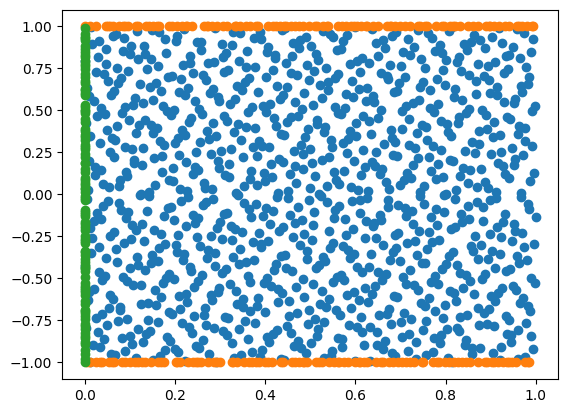

In [4]:
# Check collocation & boundary points
plt.scatter(t_dm.detach().cpu().numpy(), x_dm.detach().cpu().numpy())
plt.scatter(t_bc.detach().cpu().numpy(), x_bc.detach().cpu().numpy())
plt.scatter(t_init.detach().cpu().numpy(), x_init.detach().cpu().numpy())

In [5]:
model = Network().to(device)
model.apply(init_weights)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train_history = {'loss':[]}


In [6]:
n_epochs = 10000

for epoch in range(n_epochs):
  res_loss = residual_loss(model, t_dm, x_dm)
  bc_loss  = data_loss(model, t_bc, x_bc, 0)
  init_loss = data_loss(model, t_init, x_init, u_init_data)
  loss = res_loss + 5*bc_loss + 5*init_loss

  # Save history
  if epoch%10 == 0:
    train_history['loss'].append(float(loss.detach().cpu().numpy()))

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  if epoch%1000 ==0:
    print(f'Epoch: {epoch}, Loss: {float(loss):.2}, BC Loss: {float(bc_loss):.3}, Init Loss: {float(init_loss):.3}')



Epoch: 0, Loss: 2.3, BC Loss: 0.134, Init Loss: 0.308
Epoch: 1000, Loss: 0.17, BC Loss: 7.56e-05, Init Loss: 0.00824
Epoch: 2000, Loss: 0.025, BC Loss: 2.15e-05, Init Loss: 0.0011
Epoch: 3000, Loss: 0.0066, BC Loss: 3.73e-05, Init Loss: 0.000274
Epoch: 4000, Loss: 0.0032, BC Loss: 4.01e-06, Init Loss: 0.000149
Epoch: 5000, Loss: 0.0022, BC Loss: 1.14e-05, Init Loss: 0.000132
Epoch: 6000, Loss: 0.0015, BC Loss: 7.44e-06, Init Loss: 7.53e-05
Epoch: 7000, Loss: 0.0026, BC Loss: 1.97e-06, Init Loss: 0.000137
Epoch: 8000, Loss: 0.0014, BC Loss: 6.77e-06, Init Loss: 5.3e-05
Epoch: 9000, Loss: 0.0025, BC Loss: 9.34e-06, Init Loss: 4.76e-05


In [7]:
t_test_domain = np.linspace(0, 1, 200)
x_test_domain = np.linspace(-1, 1, 200)
T_test, X_test = np.meshgrid(t_test_domain, x_test_domain)
T_input = torch.from_numpy(T_test).to(dtype=torch.float32).to(device).flatten()[:,None]
X_input = torch.from_numpy(X_test).to(dtype=torch.float32).to(device).flatten()[:,None]

U_test = model(T_input, X_input).detach().cpu().numpy().reshape(200, 200)

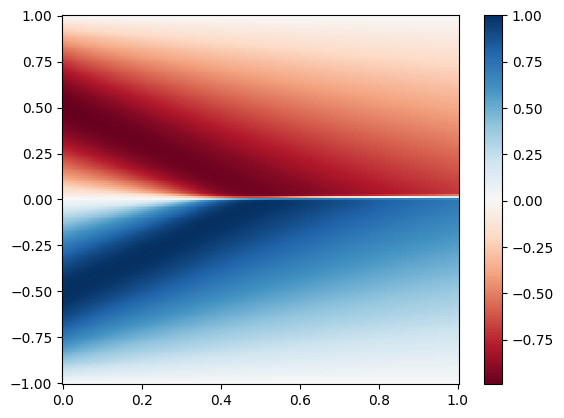

In [8]:
fig, ax = plt.subplots()

p = ax.pcolor(T_test, X_test, U_test, cmap=matplotlib.cm.RdBu, vmin=U_test.min(), vmax=U_test.max())
cb = fig.colorbar(p, ax=ax)